# SciKit-LearnML Experimentation

In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools

from classifier_utilities import *

### importing datasets

In [2]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()
label_image = merge_classes(label_image)


l8_image_paths = [
    '/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
    '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined.tif'
]

s1_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined/aligned-LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined/aligned-LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined/aligned-LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined/aligned-LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined/aligned-LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_SAR.tif',
]

dem_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-77.7672_35.00779_-75.79042_36.58923__4500X4262_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-78.07896_33.69485_-76.14021_35.27466__4500X4248_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-76.14021_34.71847_-74.14865_36.318__4500X4408_ShowLogo_False_tiff_depth=32f.tiff',
]


landsat_datasets = []
for fp in l8_image_paths:
    landsat_datasets.append(rasterio.open(fp))
    
sentinel_datasets = []
for fp in s1_image_paths:
    sentinel_datasets.append(rasterio.open(fp))
    
dem_datasets = []
for fp in dem_image_paths:
    dem_datasets.append(rasterio.open(fp))


### Class Dictionary and Confusion Matrix Function

In [3]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))

## Scikit-learn ML Approaches

### Prep Data for training and validation

In [4]:
# get pixel locations
train_pixels = gen_balanced_pixel_locations(image_datasets=landsat_datasets[4:], train_count=50000, 
                                            label_dataset=label_dataset, merge=False)


train_to_val_ratio = 0.8
train_px = train_pixels[:int(len(train_pixels)*train_to_val_ratio)]
val_px = train_pixels[int(len(train_pixels)*train_to_val_ratio):]

100%|██████████| 1/1 [01:25<00:00, 85.46s/it]


In [5]:
# get training data from those pixel locations
batch_size = len(train_px)
sk_im_batch, sk_label_batch = pixel_generator(landsat_datasets[4:], sentinel_datasets[4:], dem_datasets[4:], 
                                              label_dataset, train_px, batch_size, merge=False)
print(sk_im_batch.shape, sk_label_batch.shape)

(32823, 10) (32823, 26)


In [6]:
batch_size = len(val_px)
sk_im_batch_val, sk_label_batch_val = pixel_generator(landsat_datasets[4:], sentinel_datasets[4:], 
                                            dem_datasets[4:], label_dataset, val_px, batch_size, merge=False)
print(sk_im_batch_val.shape, sk_label_batch_val.shape)

(8206, 10) (8206, 26)


In [7]:
unique, counts = np.unique(np.argmax(sk_label_batch, axis=1), return_counts=True)
dict(zip(unique, counts))

{2: 1400,
 3: 1826,
 4: 1870,
 5: 1866,
 6: 1861,
 7: 76,
 8: 1783,
 9: 1803,
 10: 1886,
 11: 1789,
 12: 1848,
 13: 1965,
 14: 1918,
 15: 1892,
 16: 2,
 17: 1743,
 18: 1942,
 19: 1809,
 20: 1683,
 21: 1854,
 22: 7}

### K Nearest Neighbors

Create an instance of Neighbours Classifier and fit the data.

In [8]:
from sklearn import neighbors, datasets

n_neighbors = 50

clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=50, p=2,
           weights='distance')

Now assess the model

In [9]:
label_index = np.argmax(sk_label_batch_val, axis=1)

clf.score(sk_im_batch_val, label_index)

0.45101145503290274

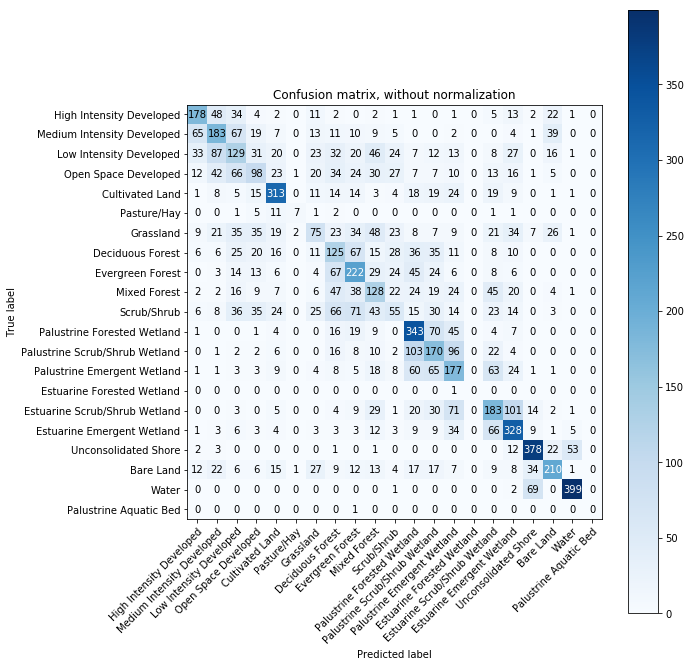

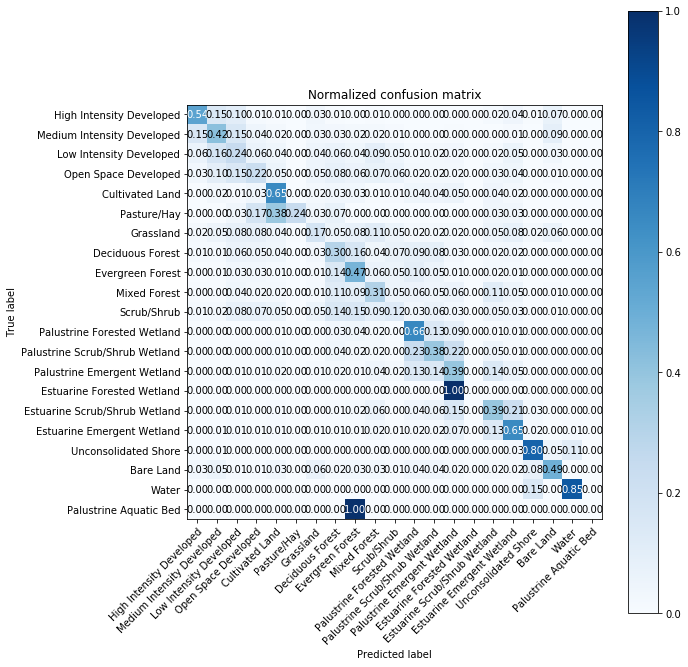

In [10]:
pred_index = clf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

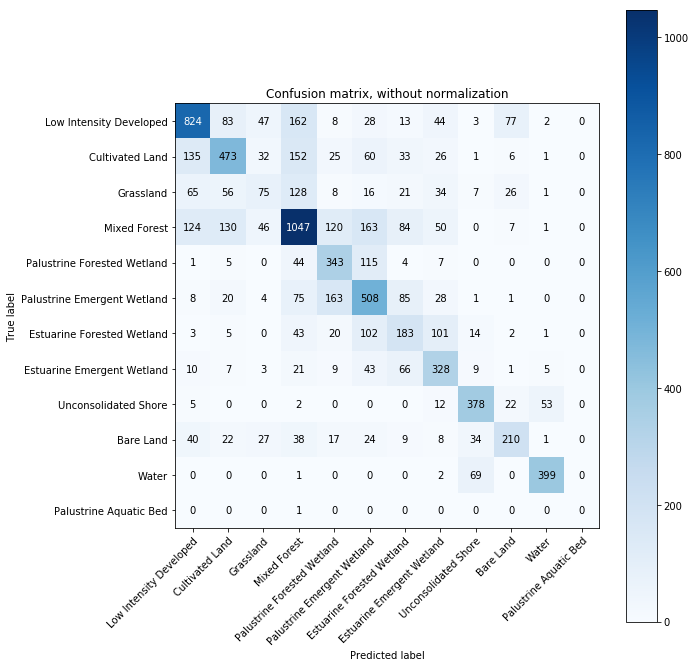

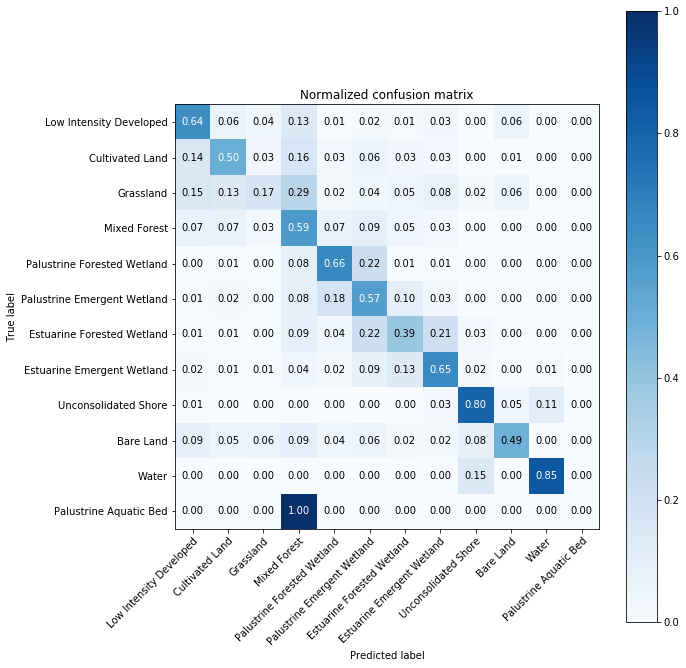

In [12]:
pred_index = merge_classes_extra(pred_index)
label_index = merge_classes_extra(label_index)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [11]:
def merge_classes_extra(y):
    # medium intensity and high intensity
    y[y == 3] = 2
    # open space developed, cultivated land, and pasture hay
    y[y == 5] = 6
    y[y == 7] = 6
    # decidious and mixed
    y[y == 9] = 11
    # evergreen and scrub shrub
    y[y == 12] = 10
    # pal wetland and pal scrub shrub
    y[y == 14] = 15
    # est forest and est scrub shrub
    y[y == 17] = 16
    
    ###
    # merge developed
    y[y == 2] = 4
    # merge evergreen and mixed forest
    y[y == 10] = 11
    
    return(y)

(array([327., 435., 529., 436., 479.,  29., 437., 419., 471., 414., 468.,
        519., 442., 451.,   1., 473., 502., 472., 430., 472.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22.]),
 <a list of 20 Patch objects>)

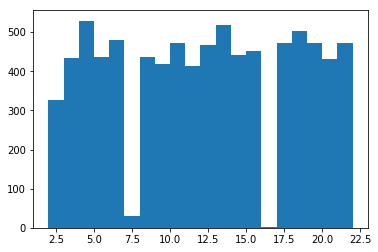

In [13]:
plt.hist(np.argmax(sk_label_batch_val, axis=1), bins=20)

(array([1215.,    0.,  801.,    0.,  234.,    0.,    0.,    0., 1714.,
           0.,  713.,    0., 1059.,    0.,  498.,    0.,  640.,  516.,
         352.,  464.]),
 array([ 4.  ,  4.85,  5.7 ,  6.55,  7.4 ,  8.25,  9.1 ,  9.95, 10.8 ,
        11.65, 12.5 , 13.35, 14.2 , 15.05, 15.9 , 16.75, 17.6 , 18.45,
        19.3 , 20.15, 21.  ]),
 <a list of 20 Patch objects>)

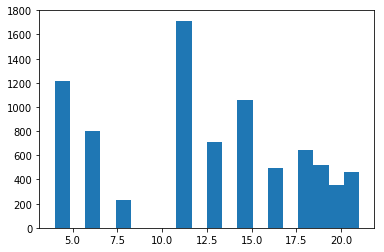

In [14]:
plt.hist(pred_index, bins=20)

### Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

In [16]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 56.84428601895013%


In [17]:
rf.score(sk_im_batch_val, label_index)

0.3642456738971484

In [18]:
bands = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.09182995969393912
Band 2 importance: 0.09735541407263433
Band 3 importance: 0.08752281391494388
Band 4 importance: 0.08941049394694285
Band 5 importance: 0.11136015748057518
Band 6 importance: 0.10717267311870611
Band 7 importance: 0.10358218669534916
Band 8 importance: 0.09754790019971284
Band 9 importance: 0.09218368660738635
Band 10 importance: 0.12203471426981023


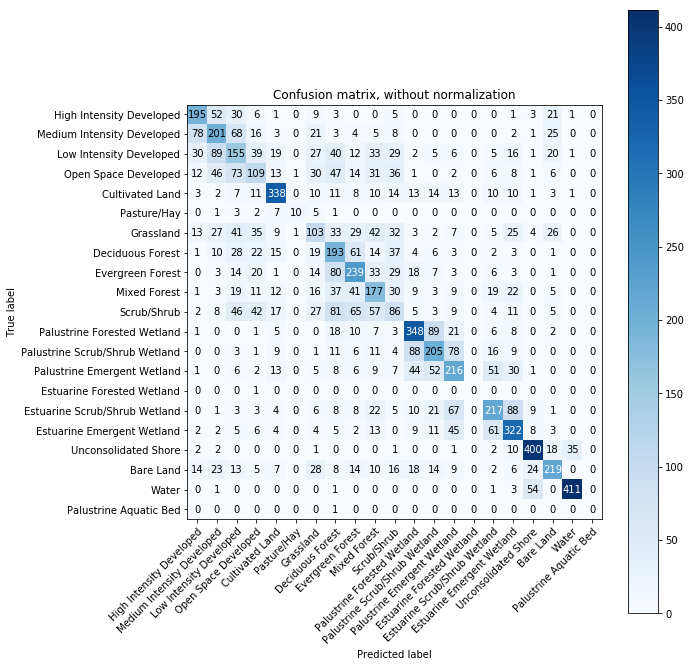

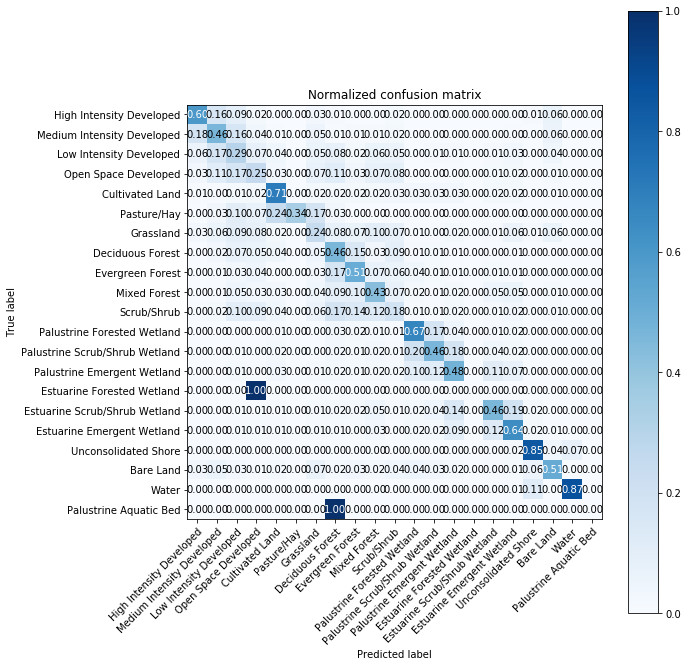

In [19]:
pred_index = rf.predict(sk_im_batch_val)
label_index = np.argmax(sk_label_batch_val, axis=1)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

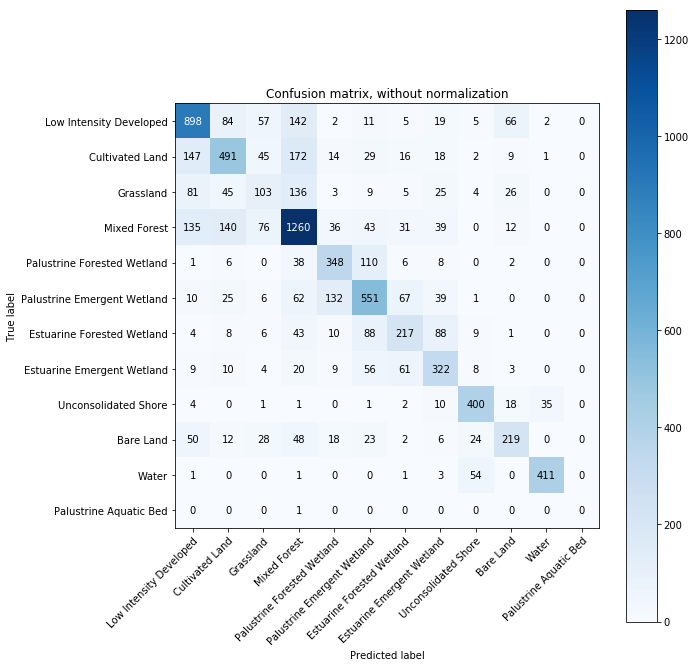

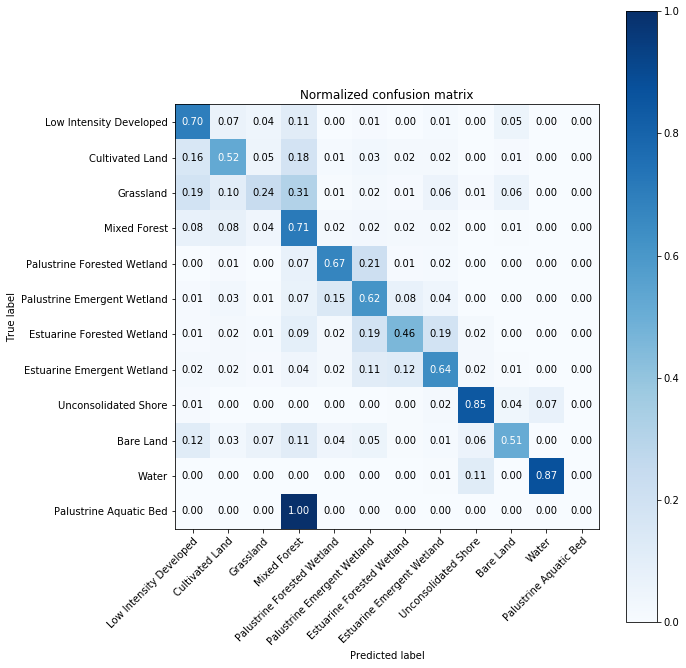

In [21]:
pred_index = merge_classes_extra(pred_index)
label_index = merge_classes_extra(label_index)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

(array([1340.,    0.,  821.,    0.,  326.,    0.,    0.,    0., 1924.,
           0.,  572.,    0.,  921.,    0.,  413.,    0.,  577.,  507.,
         356.,  449.]),
 array([ 4.  ,  4.85,  5.7 ,  6.55,  7.4 ,  8.25,  9.1 ,  9.95, 10.8 ,
        11.65, 12.5 , 13.35, 14.2 , 15.05, 15.9 , 16.75, 17.6 , 18.45,
        19.3 , 20.15, 21.  ]),
 <a list of 20 Patch objects>)

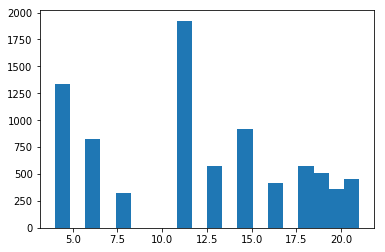

In [22]:
plt.hist(pred_index, bins=20)

#### Creating training data that contains a 3x3 tile

In [23]:
batch_size = len(train_px)
sk_im_batch, sk_label_batch = sk_tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, 7, 7, train_px, batch_size, merge=False)
print(sk_im_batch.shape, sk_label_batch.shape)

(32823, 490) (32823, 26)


In [24]:
batch_size = len(val_px)
sk_im_batch_val, sk_label_batch_val = sk_tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, 7, 7, val_px, batch_size, merge=False)
print(sk_im_batch_val.shape, sk_label_batch_val.shape)

(8206, 490) (8206, 26)


In [25]:
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

In [26]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 100.0%


In [27]:
label_index = np.argmax(sk_label_batch_val, axis=1)

rf.score(sk_im_batch_val, label_index)

0.6118693638800877

In [28]:
bands = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.0014906754902459785
Band 2 importance: 0.0014123066939219601
Band 3 importance: 0.0014312665779239327
Band 4 importance: 0.001319761453361226
Band 5 importance: 0.0016542782767735554
Band 6 importance: 0.0013676053988538606
Band 7 importance: 0.0013424522706975681
Band 8 importance: 0.001965979019403379
Band 9 importance: 0.0020285101201014334
Band 10 importance: 0.0018644414695928911


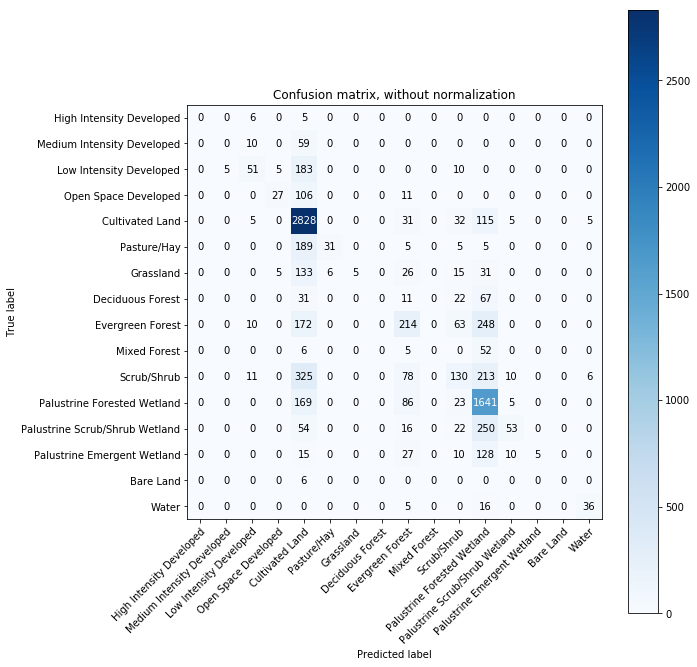

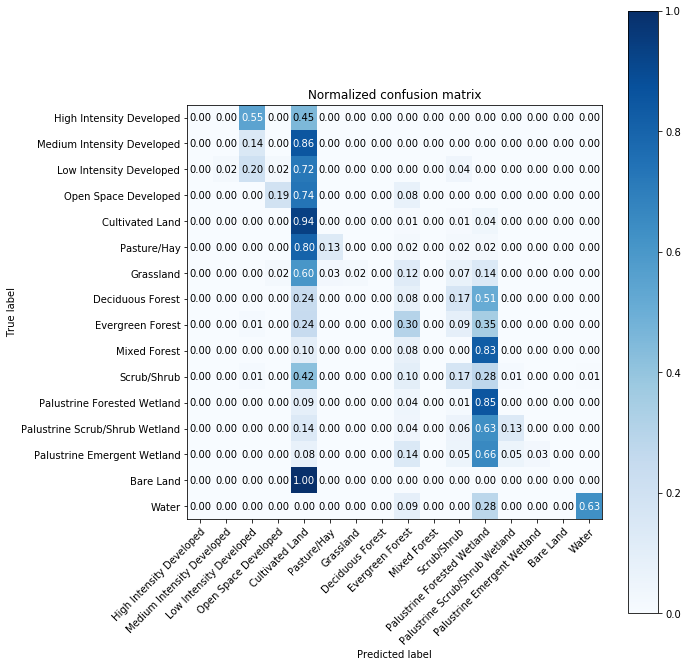

In [29]:
pred_index = rf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

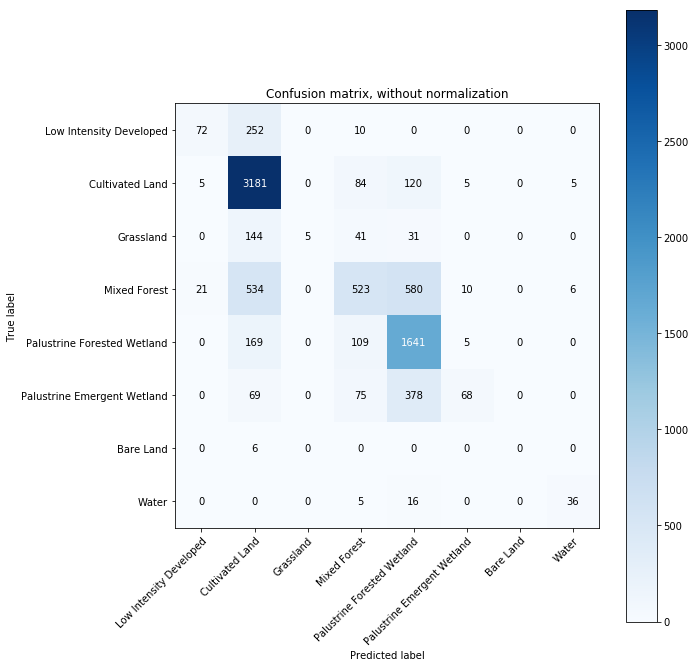

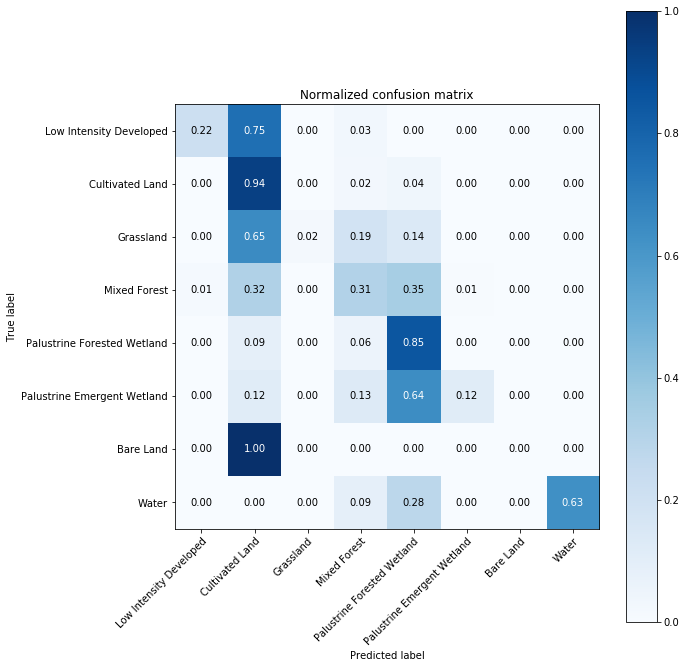

In [30]:
pred_index = merge_classes_extra(pred_index)
label_index = merge_classes_extra(label_index)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

### SVM

In [40]:
from sklearn import svm
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [41]:
svm_clf.score(sk_im_batch_val, np.argmax(sk_label_batch_val, axis=1))

0.3393730227207363

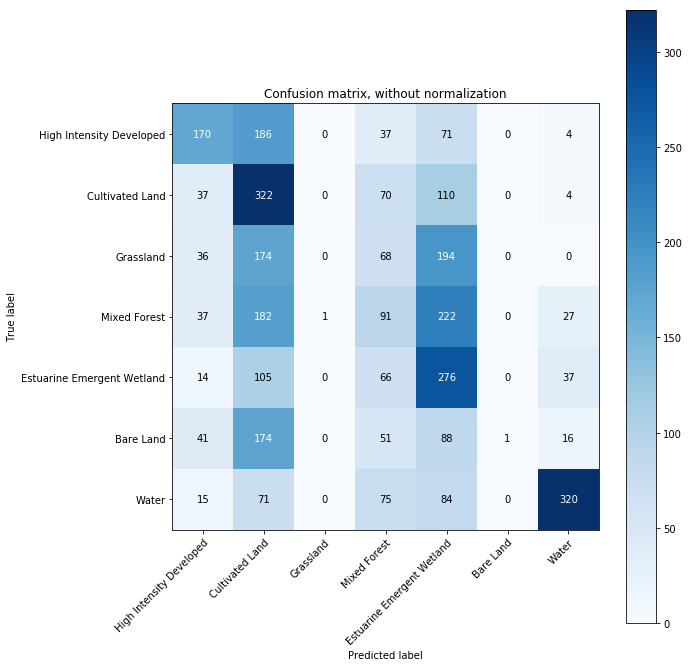

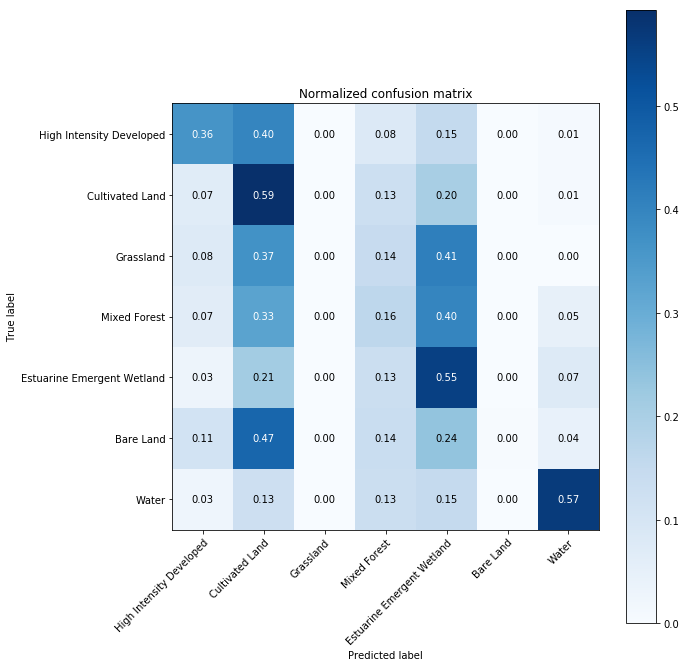

In [42]:
pred_index = svm_clf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)